In [1]:
import crepe
import librosa
import librosa.feature
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import soundfile as sf
# import fluidsynth
import os
from time import sleep

In [2]:
filename = "wav/4_Feel_Good_Inc.wav"
y, sr = librosa.load(filename, sr=None)
# y = y[15000:int(-0.9 * sr)]

# Trim leading and trailing silence
# y, _ = librosa.effects.trim(y, top_db=20, frame_length=512, hop_length=64)

# pitch shift 
# y = librosa.effects.pitch_shift(y, sr=sr, n_steps=12)

In [3]:
Audio(y, rate=sr)

Text(0.5, 1.0, 'Sample 2')

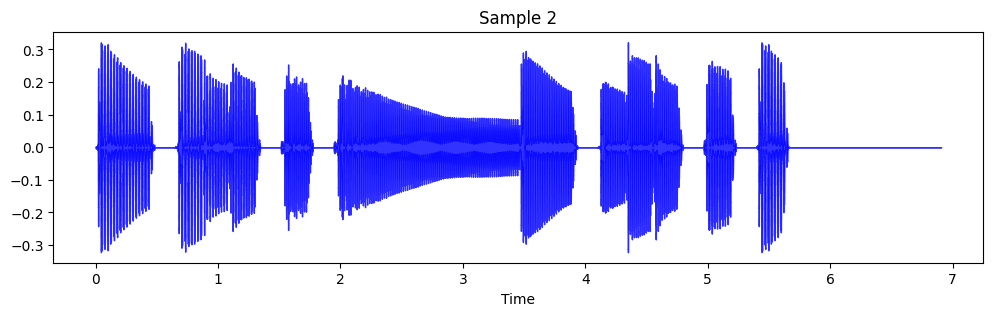

In [4]:
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, color="b", alpha=0.8)
plt.title(f"Sample 2")

In [149]:
# Create tmp folder if not exists
if not os.path.exists("tmp"):
    os.mkdir("tmp")

In [5]:
# Run CREPE
time, frequency, confidence, activation = crepe.predict(y, sr, viterbi=True, model_capacity="full", step_size=10)

22/22 [==============================] - 7s 306ms/step


Text(0, 0.5, 'Confidence')

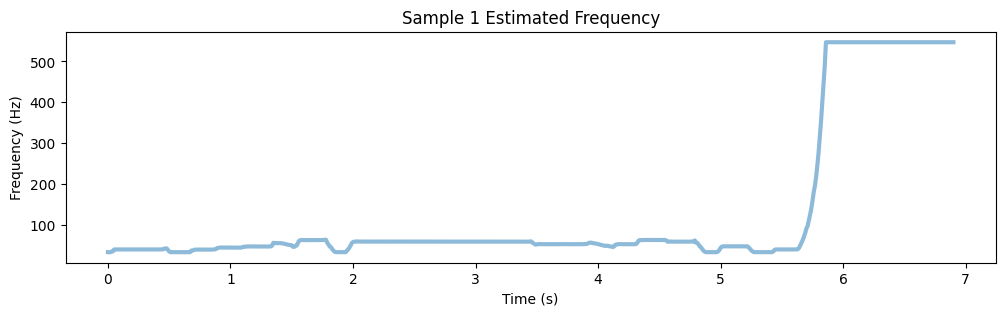

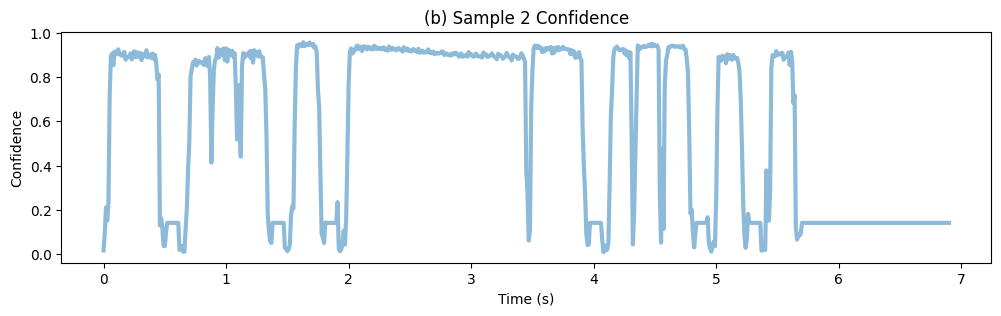

In [6]:
# Plot the frequency and confidence
plt.figure(figsize=(12, 3))
plt.plot(time, frequency, linewidth=3, alpha=0.5, label="Frequency (Hz)")
plt.title("Sample 1 Estimated Frequency")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.figure(figsize=(12, 3))
plt.plot(time, confidence, linewidth=3, alpha=0.5, label="Confidence (Hz)")
plt.title("(b) Sample 2 Confidence")
plt.xlabel("Time (s)")
plt.ylabel("Confidence")

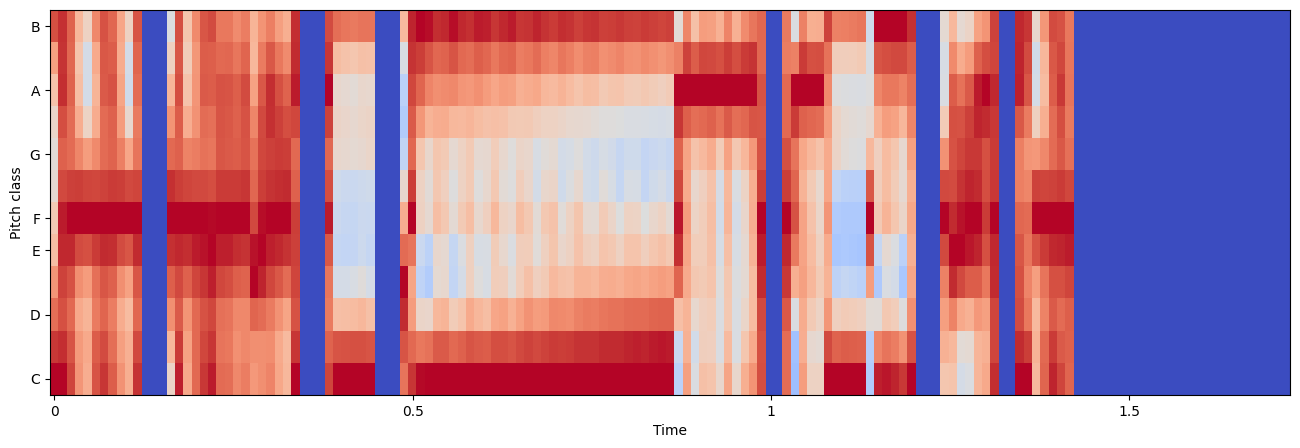

In [7]:
# Plot chromagram
# C = librosa.cqt(y, sr=sr, fmin=50, n_bins=72)
# logC = librosa.amplitude_to_db(np.abs(C))

chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=2048)
plt.figure(figsize=(16,5))
librosa.display.specshow(chromagram, sr=sr, hop_length=512, x_axis='time', y_axis='chroma', cmap='coolwarm')

Text(0.5, 1.0, '(a) Quantized Frequency (Hz)')

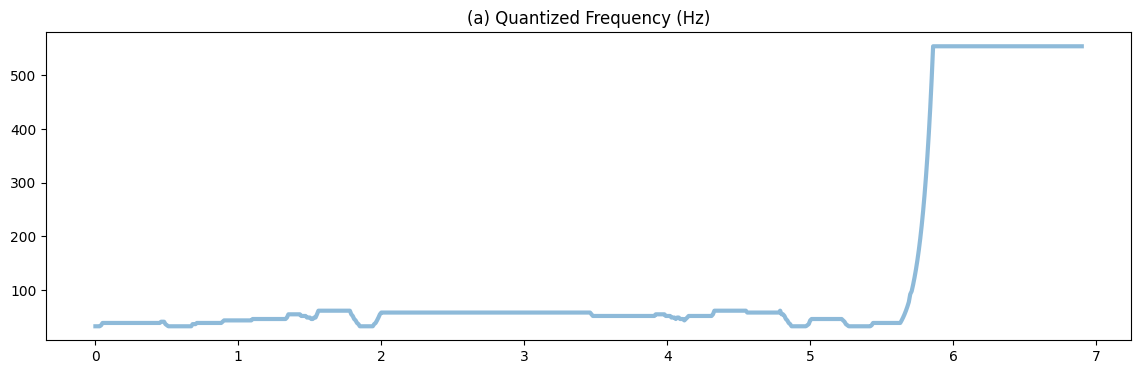

In [8]:
# Quantize the frequency to the nearest note in MIDI
# frequency_quantized = np.zeros_like(frequency)
# for i, f in enumerate(frequency):
#     if confidence[i] > 0.50:
#         frequency_quantized[i] = librosa.note_to_hz(librosa.hz_to_note(f))
#     elif confidence[i] > 0.1:
#         frequency_quantized[i] = f
#     else:
#         frequency_quantized[i] = 0 
frequency_quantized = np.array(
    list(map(lambda x: librosa.note_to_hz(librosa.hz_to_note(x)) if x > 0 else 0, frequency)))
        
# Plot the quantized frequency and confidence
plt.figure(figsize=(14, 4))
plt.plot(time, frequency_quantized, linewidth=3, alpha=0.5, label="Frequency (Hz)")
plt.title("(a) Quantized Frequency (Hz)")

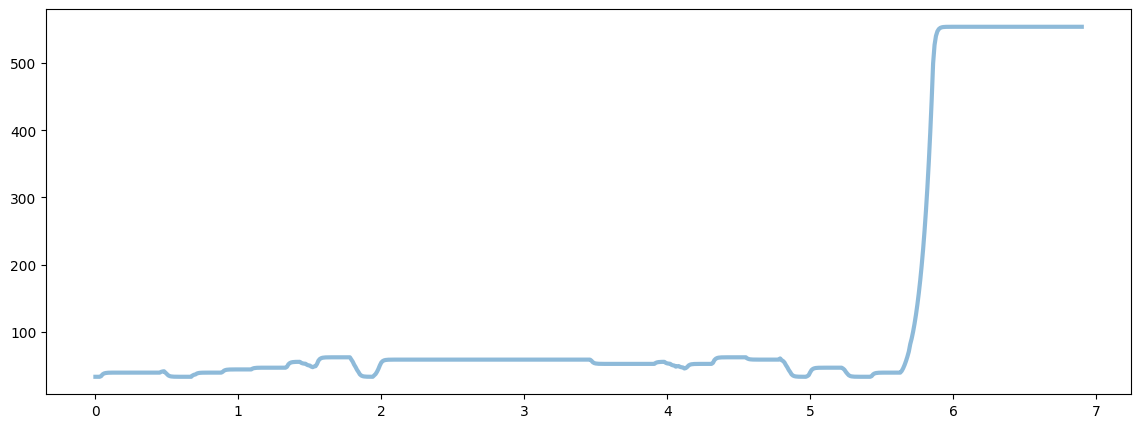

In [9]:
# smooth the frequency
frequency_quantized_smooth = np.zeros_like(frequency_quantized)
for i, f in enumerate(frequency_quantized):
    if i == 0:
        frequency_quantized_smooth[i] = f
    else:
        frequency_quantized_smooth[i] = (frequency_quantized_smooth[i - 1] + f) / 2
# Plot the quantized frequency and confidence
plt.figure(figsize=(14, 5))
plt.plot(time, frequency_quantized_smooth, linewidth=3, alpha=0.5, label="Frequency (Hz)")

In [11]:
output = None
for f in frequency_quantized_smooth:
    f = f / 5
    if output is None:
        output = np.linspace(0, f, int(sr * 0.01))
    else:
        output = np.concatenate([output, np.linspace(0, f, int(sr * 0.01))])

output_sin = np.sin(2 * np.pi * output)

Audio(output_sin, rate=sr)

NameError: name 'frequency_quantized_smooth' is not defined

In [10]:
midis = [round(librosa.hz_to_midi(f)) for f in frequency]

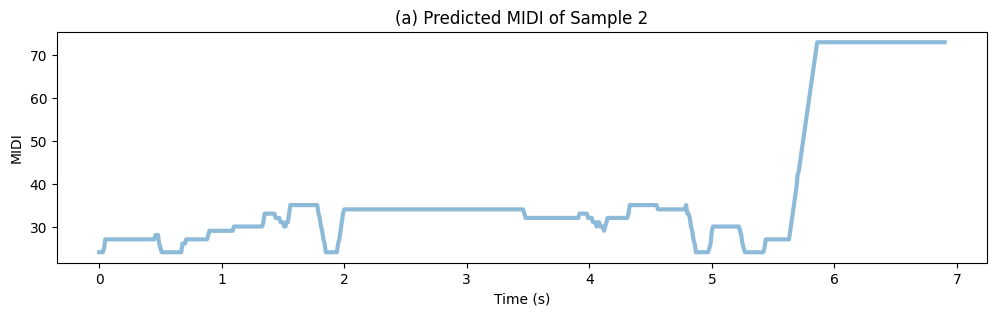

In [11]:
# Plot midis
plt.figure(figsize=(12, 3))
plt.plot(time, midis, linewidth=3, alpha=0.5, label="MIDI")
plt.title("(a) Predicted MIDI of Sample 2")
plt.xlabel("Time (s)")
plt.ylabel("MIDI")

# Save plot
plt.savefig("tmp/midis.png")

In [12]:
fs = fluidsynth.Synth()
fs.start()
sfid = fs.sfload("synth/StrixGuitarPack.sf2")
fs.program_select(0, sfid, 13, 33)

for m in midis:
    fs.noteon(0, m, 120)
    sleep(0.02)
    fs.noteoff(0, m)

fs.delete()

fluidsynth: error: fluid_sfloader_load(): Failed to open 'synth/StrixGuitarPack.sf2': File does not exist.
fluidsynth: error: Unable to open file 'synth/StrixGuitarPack.sf2'
fluidsynth: error: Failed to load SoundFont "synth/StrixGuitarPack.sf2"
fluidsynth: error: There is no preset with bank number 13 and preset number 33 in SoundFont -1


## Onset Detection

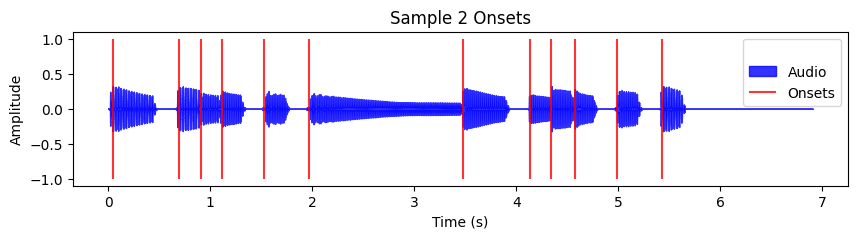

In [25]:
# Onset detection
hop_length = 1024
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units="frames", hop_length=hop_length, wait=1, delta=0.05)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)

# Plot audio and vertical lines at the onset times
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y, sr=sr, color="b", alpha=0.8)
plt.vlines(onset_times, -1, 1, color="r", alpha=0.8)
plt.legend(["", "Audio", "Onsets"])
plt.title(f"Sample 2 Onsets")
plt.ylabel("Amplitude") 
plt.xlabel("Time (s)")

# Add clicks
onset_clicks = librosa.clicks(times=onset_times, sr=sr, length=len(y))
Audio(y + onset_clicks, rate=sr)

In [26]:
# if onsets are too close, remove them
onset_times = np.array([o for i, o in enumerate(onset_times) if i == 0 or o - onset_times[i - 1] > 0.1])

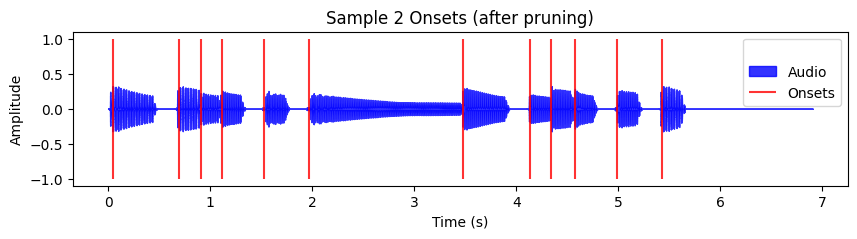

In [27]:
# Plot audio and vertical lines at the onset times
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y, sr=sr, color="b", alpha=0.8)
plt.vlines(onset_times, -1, 1, color="r", alpha=0.8)
plt.legend(["", "Audio", "Onsets"])
plt.title(f"Sample 2 Onsets (after pruning)")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

# Save plot
plt.savefig("tmp/onsets.png")

In [28]:
# Add clicks
onset_clicks = librosa.clicks(times=onset_times, sr=sr, length=len(y))
Audio(y + onset_clicks, rate=sr)

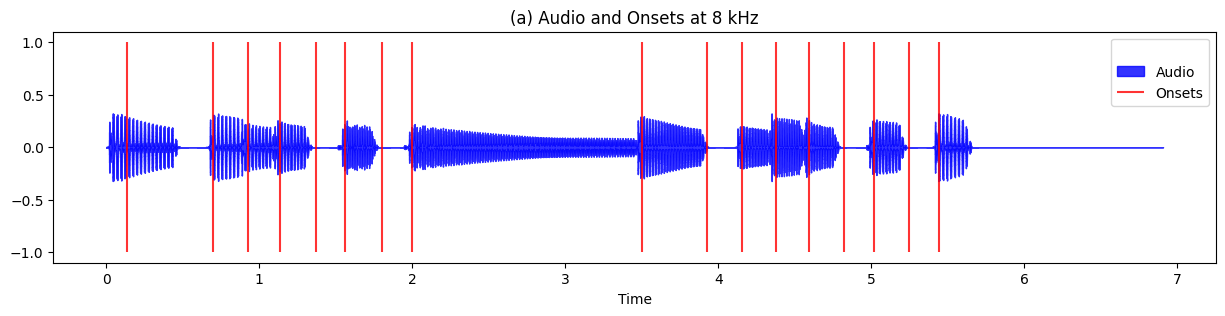

In [21]:
# Try with 8kHz sample
y_8khz, sr_8khz = librosa.load("wav/4_Feel_Good_Inc.wav", sr=8000)

# Onset detection
hop_length = 64
onset_frames = librosa.onset.onset_detect(y=y_8khz, sr=sr_8khz, units="frames", hop_length=hop_length, wait=1, delta=0.01, backtrack=False)
onset_times = librosa.frames_to_time(onset_frames, sr=sr_8khz, hop_length=hop_length)

# Remove onsets that are too close
onset_times = np.array([o for i, o in enumerate(onset_times) if i == 0 or o - onset_times[i - 1] > 0.1])

# Plot audio and vertical lines at the onset times
plt.figure(figsize=(15, 3))
librosa.display.waveshow(y_8khz, sr=sr_8khz, color="b", alpha=0.8)
plt.vlines(onset_times, -1, 1, color="r", alpha=0.8)
plt.legend(["", "Audio", "Onsets"])
plt.title(f"(a) Audio and Onsets at {sr_8khz // 1000} kHz")

# Add clicks
onset_clicks = librosa.clicks(times=onset_times, sr=sr_8khz, length=len(y_8khz))
Audio(y_8khz + onset_clicks, rate=sr_8khz)

In [29]:
# Segment the audio into chunks
segments = []
for i, o in enumerate(onset_times):
    if i == 0:
        segments.append(y[:int(o * sr)])
    else:
        segments.append(y[int(onset_times[i - 1] * sr):int(o * sr)])

segments.append(y[int(onset_times[-1] * sr):])

In [30]:
# pad segments to 200ms, concatenate them, and play
segments_padded = []
for s in segments:
    if len(s) < sr * 0.5:
        s = np.concatenate([s, np.zeros(int(sr * 0.5 - len(s)))])
    segments_padded.append(s)

Audio(np.concatenate(segments_padded), rate=sr)

In [31]:
durations = [onset_times[i + 1] - onset_times[i] for i in range(len(onset_times) - 1)]
durations.append(0.2)

In [32]:
detected_midis = []

n = len(frequency_quantized)
m = 3  # m is the number of frames to look behind and ahead of an onset
for t in onset_times:
    idx = min(n - 1, round((t + 0.04) / 0.01))
    chunk = frequency_quantized[max(0, idx - m):min(n - 1, idx + m)]
    chunk = np.array(
        list(map(round, map(lambda x: librosa.hz_to_midi(x) if x > 0 else 0, chunk))))

    # take the most frequent midi in the chunk
    midi = round(np.bincount(chunk).argmax())
    detected_midis.append(midi)

In [34]:
# Generate audio: play each note at 'duration' seconds with fluidsynth
fs = fluidsynth.Synth(samplerate=sr)
# fs.start()
sfid = fs.sfload("sf/StrixGuitarPack.sf2")
fs.program_select(0, sfid, 0, 34)

s = np.zeros(int(sr * 0.01))
for m, d in zip(detected_midis, durations):
    m = m + 12
    fs.noteon(0, m, 50)
    s = np.append(s, fs.get_samples(round(sr * d / 2)))
    fs.noteoff(0, m)

fs.delete()

# Output s to wav file
if not os.path.exists("tmp"):
    os.mkdir("tmp")

sf.write("tmp/output.wav", s * 0.01, sr)

# Play the output
Audio(s, rate=sr)

In [91]:
[onset_times[i + 1] - onset_times[i] for i in range(len(onset_times) - 1)]


[0.10666666666666669,
 0.256,
 0.128,
 0.21333333333333326,
 0.19199999999999995,
 0.2346666666666668,
 0.19199999999999995,
 0.29866666666666664,
 0.21333333333333315,
 0.21333333333333337,
 0.14933333333333332,
 0.29866666666666664,
 0.23466666666666702,
 0.19199999999999973,
 0.23466666666666702,
 0.23466666666666658,
 0.2559999999999998,
 0.23466666666666658,
 0.10666666666666647,
 0.10666666666666735,
 0.23466666666666658,
 0.21333333333333293,
 0.17066666666666652,
 0.2560000000000002,
 0.21333333333333382,
 0.23466666666666658,
 0.21333333333333293,
 0.23466666666666658,
 0.19200000000000017,
 0.19200000000000017,
 0.21333333333333293,
 0.23466666666666658,
 0.23466666666666658,
 0.23466666666666747,
 0.17066666666666652]

In [289]:
int(305 * sr * 0.01)

146400

In [290]:
(y[10000] / (sr * 0.01))

9.282430013020833e-06

In [291]:
for o in onset_times * 100:
    print(frequency[int(o)], librosa.hz_to_note(frequency[int(o)]))


168.6226447783592 E3
195.2944049330539 G3
191.0950904843171 G3
170.94526530194838 F3
170.23818790781363 F3
155.2803159101995 D♯3
155.5168327207077 D♯3
148.59272427111048 D3
142.4026186721667 C♯3
125.4861614943161 B2
122.04734090917918 B2
129.34535745147787 C3
129.3865050497436 C3
154.73118437195066 D♯3
129.80419693727225 C3
130.11577075106567 C3
103.10330372192249 G♯2
97.12467454936126 G2
97.27772577211071 G2
144.38659324002148 D3
145.1568754740375 D3
130.2414908412702 C3
128.8158148612987 C3
109.56673900592462 A2
103.43151185393936 G♯2
69.89752782293081 C♯2
61.83769184164323 B1
65.74538152284279 C2
97.31620091187922 G2
116.4660105725683 A♯2
110.3668886069845 A2
97.96983583814762 G2
103.33493510010729 G♯2
109.13413577351676 A2
115.66247630664208 A♯2
129.55917441166685 C3
155.17064546471255 D♯3
148.70383680961243 D3
145.34255522420125 D3
173.15044645482476 F3
173.742813157028 F3
162.71924913565437 E3
144.57797192405334 D3
154.75589133255858 D♯3
135.8127667347406 C♯3


In [292]:
C = librosa.cqt(y, sr=sr, fmin=50, n_bins=72)
logC = librosa.amplitude_to_db(np.abs(C))

In [293]:
logC_thresh = logC.copy()
logC_thresh[logC < -8] = -200

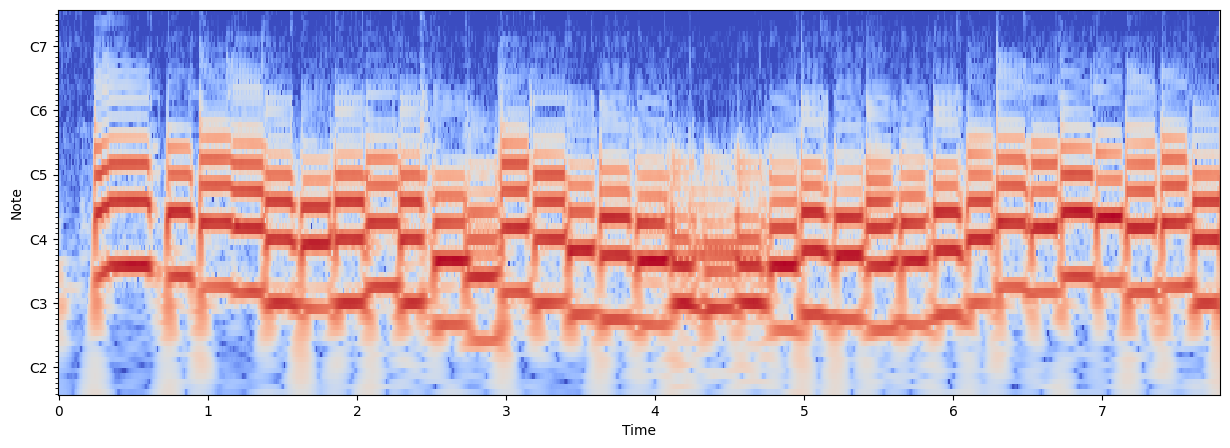

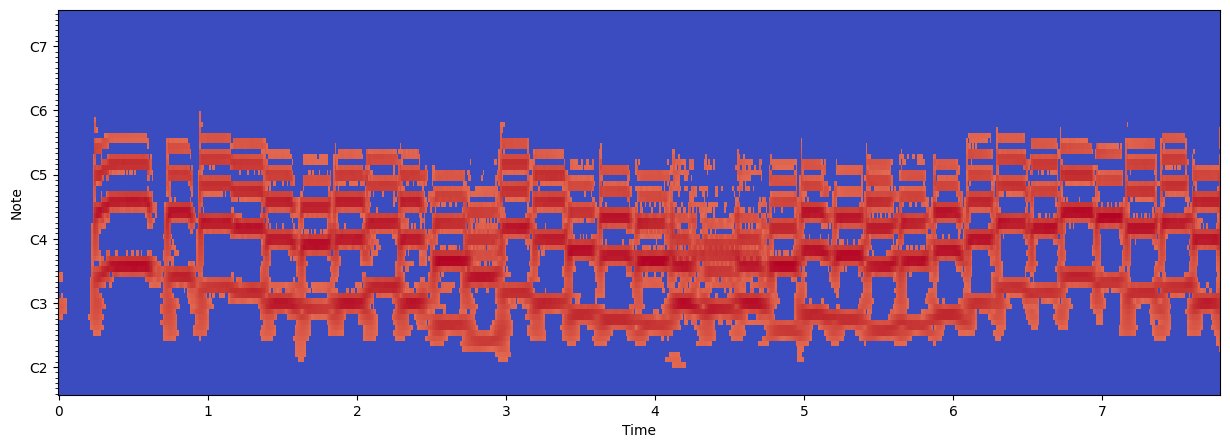

In [294]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis="time", y_axis="cqt_note", fmin=50, cmap="coolwarm")

plt.figure(figsize=(15, 5))
librosa.display.specshow(logC_thresh, sr=sr, x_axis="time", y_axis="cqt_note", fmin=50, cmap="coolwarm")

In [295]:
import math

# print(logC.shape[1], math.ceil(y.shape[0] / 512))
logC[:, 0].argmax()

bins = logC.argmax(axis=0)


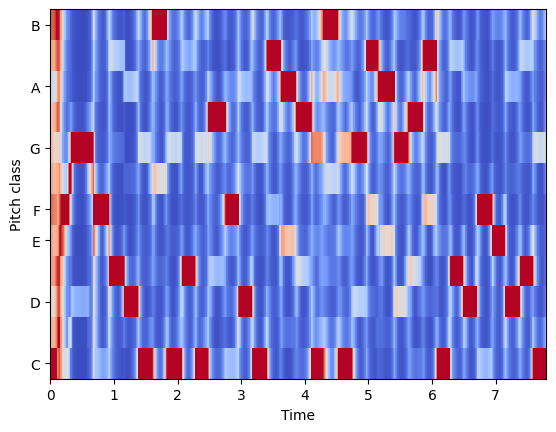

In [296]:
chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(chroma_cqt, sr=sr, x_axis="time", y_axis="chroma", cmap="coolwarm", hop_length=hop_length)

In [297]:
np.sin(2 * np.pi * np.linspace(0, 440, sr))

array([ 0.00000000e+00,  5.75652249e-02,  1.14939534e-01, ...,
       -1.14939534e-01, -5.75652249e-02,  6.27613383e-14])

In [298]:
ft = np.concatenate([np.linspace(0, 440 / 2, sr // 2), np.linspace(0, 450 / 2, sr // 2)])
Audio(np.sin(2 * np.pi * ft), rate=sr)

In [299]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2 * np.sin(2 * np.pi * f0 * n / float(sr))

In [300]:
logC.shape

(72, 731)